### Necessary import

In [1]:
import torch
import matplotlib.pyplot as plt

from lib.utils import set_seed,to_numpy
from lib.augmentations import parse_augmentations, apply_augmentations
from lib.distance.sigw1metric import SigW1Metric
from lib.datasets import get_stock_price, train_test_split
from lib.network import get_generator, get_discriminator
from lib.model.sigwgan import SigWGAN
from lib.test_metrics import get_standard_test_metrics
from lib.plot import compare_hists,plot_summary

### Hyperparameter

In [2]:
sigwgan_config = {
    "batch_size" :128,
    "epoch" : 300,
    "lr_generator" : 5e-4,
    "lr_discriminator" : 5e-4,
    "discriminator_steps_per_generator_step" : 3,
    "augmentations": [
        {"name":  "AddTime"}
    ],
    "device" : "cuda:0",
    "depth" : 4
}
data_config = {
    "ticker" : "^GSPC",
    "interval" : "1d",
    "column" : 0,  
    "window_size" : 30,
    "dir" : "datasets",
    "subdir" : "stock"
}
D_config = {
    "discriminator_type": "ResFNN",
    "hidden_dims": [20,20],
}
logsig_config = {
    "generator_type": "LogSigRNN",
    "hidden_dim": 50,
    "augmentations": [
        {"name":  "LeadLag"},
    ],
    "depth": 4,
    "input_dim": 5,
    "len_noise": 1000,
    "len_interval_u": 50,
    "init_fixed": True
}
lstm_config = {
  "generator_type": "LSTM",
  "hidden_dim": 50,
  "n_layers": 2,
  "init_fixed": True,
  "input_dim": 5
}

print(sigwgan_config['device'])

set_seed(2024)

cuda:0


In [3]:
if sigwgan_config.get('augmentations') is not None:
    sigwgan_config['augmentations'] = parse_augmentations(sigwgan_config.get('augmentations'))
if logsig_config.get('augmentations') is not None:
    logsig_config['augmentations'] = parse_augmentations(logsig_config.get('augmentations'))

### Load data

In [4]:
x_real_rolled = get_stock_price(data_config)
x_real_rolled = x_real_rolled.to(sigwgan_config['device'])
print('Total data: ', list(x_real_rolled.shape))

x_real_train, x_real_test = train_test_split(x_real_rolled, train_test_ratio=0.8, device=sigwgan_config['device'])
x_real_dim: int = x_real_rolled.shape[2]
wgan_input_dim = x_real_dim * data_config['window_size']

print("D input dim: {}".format(wgan_input_dim)) # D output dim is always 1
print("G output dim: {}".format(x_real_dim)) 

Rolled data for training, shape torch.Size([1480, 30, 1])
Total data:  [1480, 30, 1]
D input dim: 30
G output dim: 1


In [5]:
y = x_real_rolled
if logsig_config['augmentations'] is not None:
    D_input_dim = apply_augmentations(y,logsig_config["augmentations"]).shape[2]*data_config['window_size']
else: 
    D_input_dim = data_config['window_size']
print("D input dim: {}".format(D_input_dim))

D_config.update(input_dim=D_input_dim)
print(D_config)
logsig_config.update(output_dim=x_real_dim)
print(logsig_config)
lstm_config.update(output_dim=x_real_dim)
print(lstm_config)

ResFNN = get_discriminator(**D_config).to(sigwgan_config['device'])
logsig = get_generator(**logsig_config).to(sigwgan_config['device'])

ResFNN2 = get_discriminator(**D_config).to(sigwgan_config['device'])
lstm = get_generator(**lstm_config).to(sigwgan_config['device'])

D input dim: 60
{'discriminator_type': 'ResFNN', 'hidden_dims': [20, 20], 'input_dim': 60}
{'generator_type': 'LogSigRNN', 'hidden_dim': 50, 'augmentations': [LeadLag(with_time=False)], 'depth': 4, 'input_dim': 5, 'len_noise': 1000, 'len_interval_u': 50, 'init_fixed': True, 'output_dim': 1}
{'generator_type': 'LSTM', 'hidden_dim': 50, 'n_layers': 2, 'init_fixed': True, 'input_dim': 5, 'output_dim': 1}
LogSigRNN input dim: 10


### SigWGAN

In [6]:
test_metrics_train = get_standard_test_metrics(x_real_train)
test_metrics_test = get_standard_test_metrics(x_real_test)

print(test_metrics_train)
print(test_metrics_test)

[SkewnessLoss(), KurtosisLoss(), SkewnessLoss(), KurtosisLoss(), CovLoss(), CovLoss(), SigW1Loss()]
[SkewnessLoss(), KurtosisLoss(), SkewnessLoss(), KurtosisLoss(), CovLoss(), CovLoss(), SigW1Loss()]


In [7]:
logsig_SigWGAN = SigWGAN(ResFNN,logsig,x_real_rolled=x_real_rolled,
                  test_metrics_train=test_metrics_train,
                  test_metrics_test=test_metrics_test,
                  **sigwgan_config)

logsig_SigWGAN.fit(device=sigwgan_config['device'])

sig-w1 loss: 2.959303e-02: 100%|██████████| 300/300 [00:24<00:00, 12.03it/s]


In [8]:
lstm_SigWGAN = SigWGAN(ResFNN,lstm,x_real_rolled=x_real_rolled,
                  test_metrics_train=test_metrics_train,
                  test_metrics_test=test_metrics_test,
                  **sigwgan_config)
lstm_SigWGAN.fit(device=sigwgan_config['device'])

sig-w1 loss: 2.728141e-02: 100%|██████████| 300/300 [00:02<00:00, 101.74it/s]


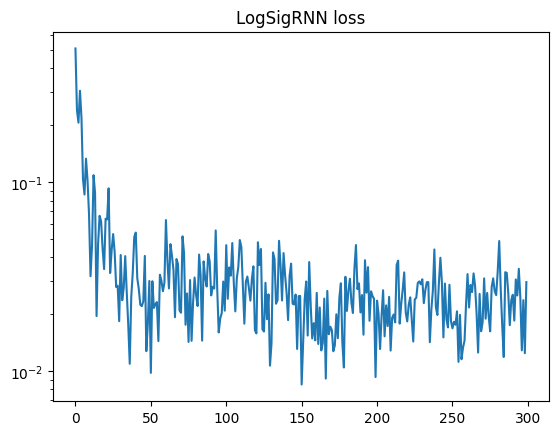

In [9]:
plt.plot(logsig_SigWGAN.losses_history['sig_w1_loss'])
plt.yscale('log')
plt.title("LogSigRNN loss")
plt.show()

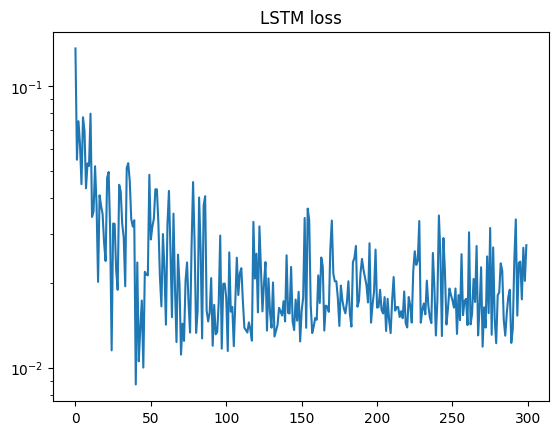

In [10]:
plt.plot(lstm_SigWGAN.losses_history['sig_w1_loss'])
plt.yscale('log')
plt.title("LSTM loss")
plt.show()

torch.Size([600, 30])


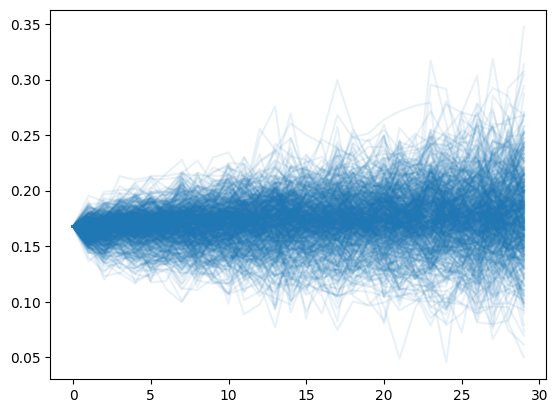

In [11]:
with torch.no_grad():
    x_fake = logsig_SigWGAN.G(600, data_config['window_size'], sigwgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(x_fake[:600, :, i]).T, 'C%s' % i, alpha=0.1)
print(x_fake[:600, :, i].shape)

torch.Size([600, 30])


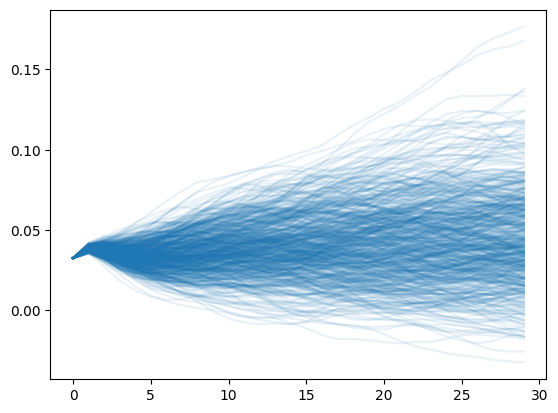

In [12]:
with torch.no_grad():
    lstm_x_fake = lstm_SigWGAN.G(600, data_config['window_size'], sigwgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(lstm_x_fake[:600, :, i]).T, 'C%s' % i, alpha=0.1)
print(lstm_x_fake[:600, :, i].shape)

torch.Size([600, 30])


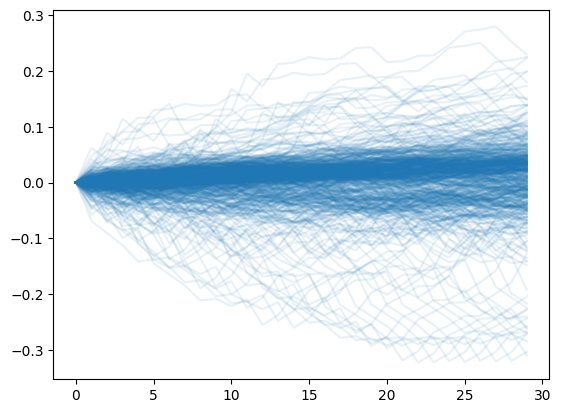

In [13]:
for i in range(x_real_dim):
    plt.plot(to_numpy(x_real_rolled[:600, :, i]).T, 'C%s' % i, alpha=0.1)
print(x_real_rolled[:600, :, i].shape)

<AxesSubplot:title={'center':'SigWGAN+LogSigRNN'}, ylabel='pdf'>

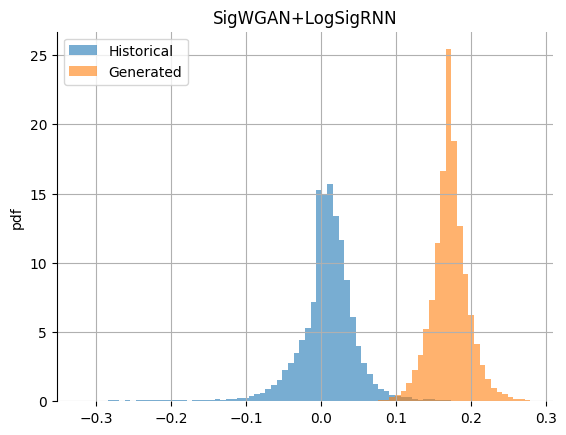

In [14]:
compare_hists(to_numpy(x_real_rolled[:1024]),to_numpy(x_fake),trainer="SigWGAN",G="LogSigRNN")

<AxesSubplot:title={'center':'SigWGAN+LSTM'}, ylabel='pdf'>

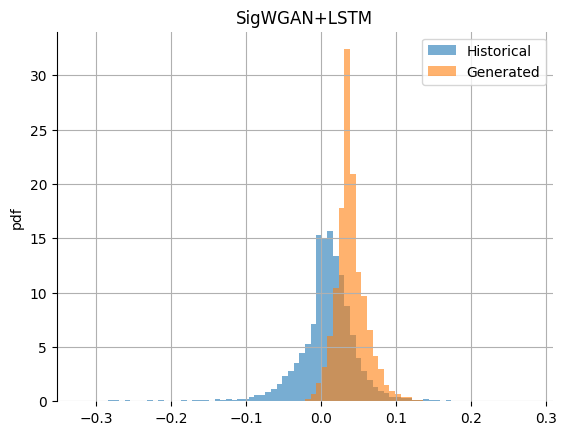

In [15]:
compare_hists(to_numpy(x_real_rolled[:1024]), to_numpy(lstm_x_fake),trainer="SigWGAN",G="LSTM")

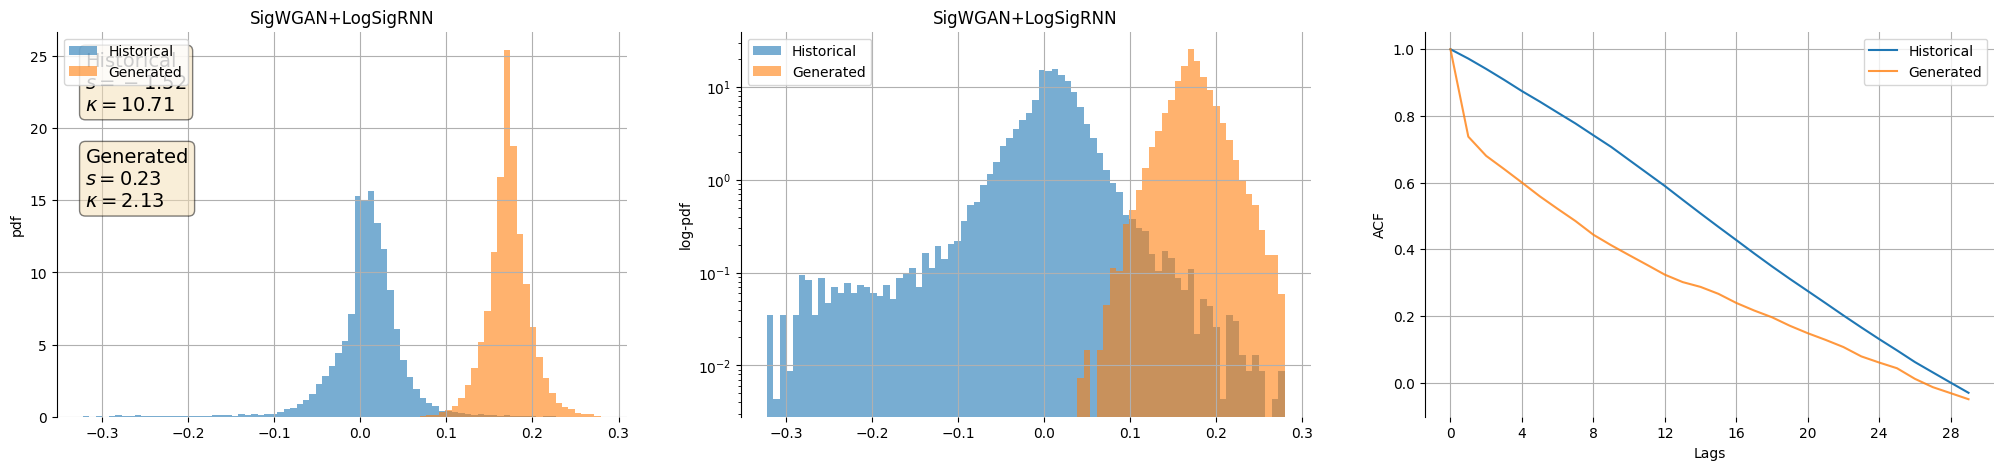

In [16]:
plot_summary(x_fake=x_fake,x_real=x_real_rolled[:1024],trainer="SigWGAN",G="LogSigRNN")

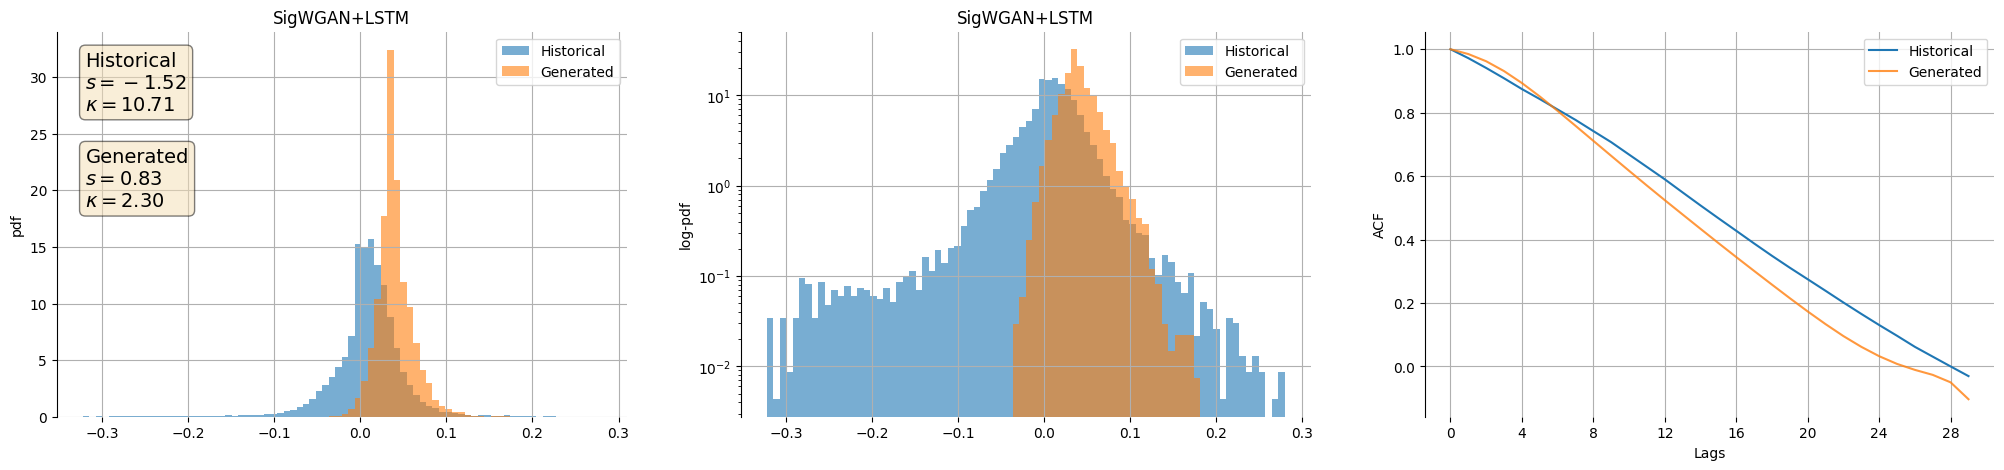

In [17]:
plot_summary(x_fake=lstm_x_fake,x_real=x_real_rolled[:1024],trainer="SigWGAN",G="LSTM")